# Bayesian sampling of ensembles

In [7]:
import os
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas

In [2]:
# import sys
# sys.path.append('../../3_alphabetagamma/')

In [3]:
# from MDRefine.MDRefine import load_data, normalize_observables, minimizer, unwrap_2dict
# from MDRefine.MDRefine import compute_chi2, compute_D_KL

In [2]:
from basic_functions import run_Metropolis, block_analysis

In [3]:
def energy_fun(new_weights, original_weights, if_Jeffreys, upto: int = 4):
    """ acting on single molecular system """

    # sys_names = data.properties.system_names
    # assert len(sys_names) == 1, 'this script works only for 1 molecular system'
    # sys_name = sys_names[0]

    # chi2 = compute_chi2(data.mol[sys_name].ref, new_weights, data.mol[sys_name].g, data.mol[sys_name].gexp)[3]
    dkl = np.sum(new_weights*np.log(new_weights/original_weights))

    # energy = 1/2*chi2 + alpha*dkl
    energy = dkl

    # quantity: population in the first frame/cluster over 4 total clusters
    quantity = np.sum(new_weights[:(len(new_weights)//upto)])
    
    # av_g = unwrap_2dict(out.av_g)[0] 

    if if_Jeffreys:
        # Jef_prior = 1/np.sqrt(np.prod(weights))
        # energy = -np.log(Jef_prior)

        # more efficient?
        energy += 1/2*np.sum(np.log(new_weights))
    
    return energy, quantity

In [4]:
def proposal(weights, dx = 0.01):
    """ Based on the stick-breaking process """

    if not np.sum(weights) == 1: weights = weights/np.sum(weights)

    x = np.cumsum(weights)[:-1]
    
    x += dx*np.random.normal(size=len(x))
    x = np.mod(x, 1)
    x = np.concatenate((np.sort(x), [1]))

    weights_new = np.concatenate(([x[0]], np.ediff1d(x)))

    return weights_new

In [5]:
def double(weights, n: int = 2):
    """ double if n = 2, else three times and so on """

    weights_double = np.zeros(len(weights)*n)

    for i in range(len(weights)):
        for j in range(n):
            weights_double[n*i + j] = weights[i]

    return weights_double

### Toy model

#### invariance

$ds^2 = \sum_i \frac{dw_i^2}{w_{0i}}$

is it invariant under coarse-graining? yes if the coarse-graining moves in the opposite direction by splitting frames into new frames with equal weights

In [7]:
w = np.array([1/8, 1/8, 1/4, 1/4, 1/8, 1/8])

w0 = np.array([1/4, 1/4, 1/8, 1/8, 1/8, 1/8])

compute_dist = lambda w, w0: np.sum((w-w0)**2)  # /w0)

d1 = compute_dist(w, w0)
print(d1)

# coarse-graining

new_w = []
new_w0 = []

for i in range(len(w)//2):
    new_w.append(w[2*i] + w[2*i + 1])
    new_w0.append(w0[2*i] + w0[2*i + 1])

new_w = np.array(new_w)
new_w0 = np.array(new_w0)

d1 = compute_dist(new_w, new_w0)
print(d1)



0.0625
0.125


#### Metropolis

In [7]:
proposal_full = {'fun': proposal, 'args': ([0.001])}

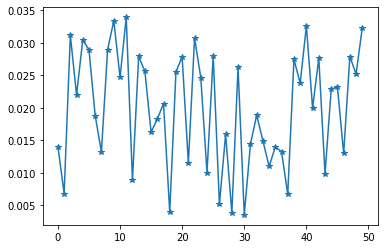

In [8]:
weights = np.random.uniform(0, 1, size=50)
weights = weights/np.sum(weights)
original_weights = +weights

plt.plot(weights, '*-')


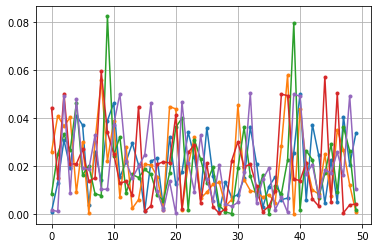

In [10]:
for i in range(5):

    new_weights = proposal(weights, dx=0.01)
    weights = new_weights

    plt.plot(new_weights, '.-')

plt.grid()

In [18]:
energy_fun_full = {'fun': energy_fun, 'args': ([original_weights, True])}

out = run_Metropolis(weights, proposal=proposal_full, energy_function=energy_fun_full, n_steps=10000)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


0.994


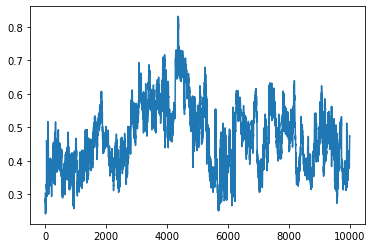

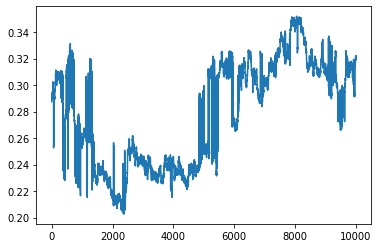

In [16]:
plt.plot(out[1])

plt.figure()
plt.plot(out[2])



print(out[3])

0.1202


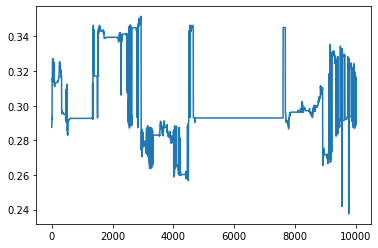

In [12]:
plt.plot(out[2])

print(out[3])

In [ ]:
# observable: average weight of the first frame over 20

In [ ]:
# plot of the sampled weights
plt.plot(out[0].T, '.')
plt.grid()
plt.show()

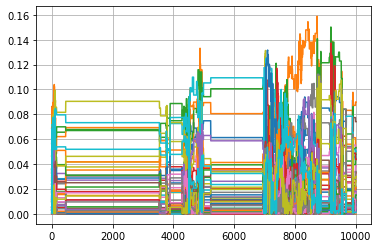

av. acceptance:  0.0473


In [122]:
plt.plot(out[0])
# plt.plot(out[0][:, 1])
plt.grid()
plt.show()

print('av. acceptance: ', out[-1])

0.27831071765278387


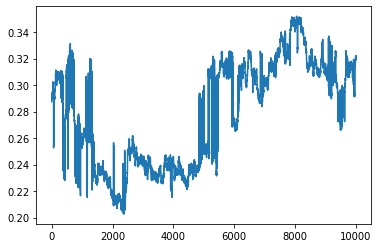

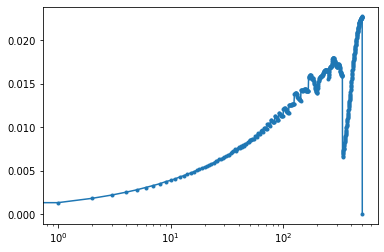

In [17]:
plt.plot(out[2])

print(np.mean(out[2]))

blocks = block_analysis(out[2], delta=10)

epsilon = blocks[2]

plt.figure()
plt.plot(epsilon, '.-')
plt.xscale('log')

In [79]:
vec = np.random.normal(size=100000)

res = block_analysis(vec, delta=100)

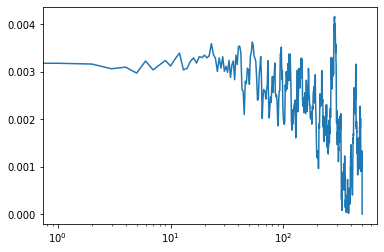

In [80]:
plt.plot(res[2])
plt.xscale('log')

#### now, inverse coarse-graining

double the frames

In [83]:
original_weights

array([0.06244842, 0.00641204, 0.05268427, 0.08010327, 0.0142057 ,
       0.08690408, 0.06127748, 0.04505012, 0.02177928, 0.03645557,
       0.02692952, 0.09029065, 0.00537328, 0.07270005, 0.03259012,
       0.07715879, 0.08648534, 0.04884211, 0.06645245, 0.02585746])

In [20]:
original_weights_double = double(original_weights)

In [26]:
proposal_full = {'fun': proposal, 'args': ([0.0001])}
energy_fun_full = {'fun': energy_fun, 'args': ([original_weights_double, False])}

out = run_Metropolis(original_weights_double, proposal=proposal_full, energy_function=energy_fun_full, n_steps=10000)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


0.28201960630475026


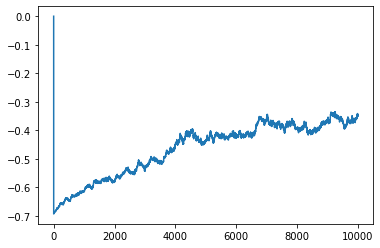

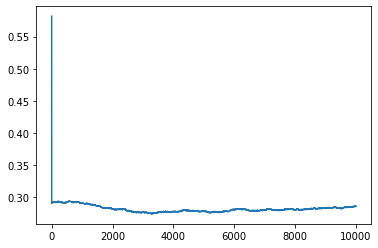

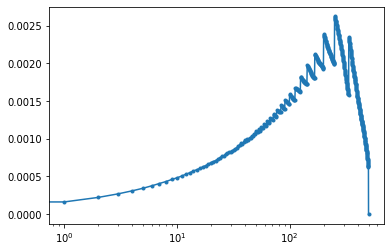

In [27]:
plt.plot(out[1])

plt.figure()
plt.plot(out[2])

print(np.mean(out[2]))

blocks = block_analysis(out[2], delta=10)

epsilon = blocks[2]

plt.figure()
plt.plot(epsilon, '.-')
plt.xscale('log')

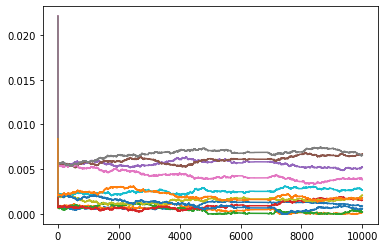

In [158]:
for i in range(12):
    plt.plot(out[0][:, i])


# plt.yscale('log')



av. acceptance:  0.5409
0.23302306925303404


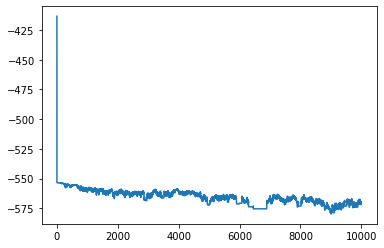

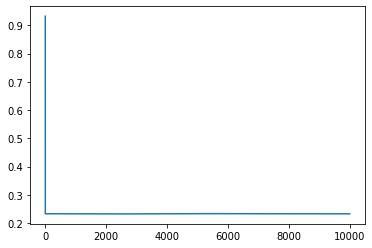

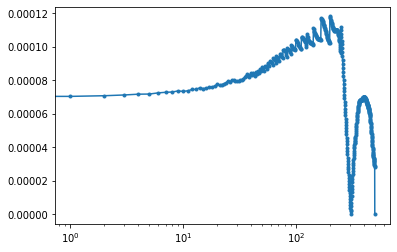

In [140]:
print('av. acceptance: ', out[3])

plt.plot(out[1])

plt.figure()
plt.plot(out[2])

print(np.mean(out[2]))

blocks = block_analysis(out[2], delta=10)

epsilon = blocks[2]

plt.figure()
plt.plot(epsilon, '.-')
plt.xscale('log')

In [131]:
original_weights_double2 = double(original_weights_double)

### Toy model - wrap up

In [51]:
size = 4

<BarContainer object of 4 artists>

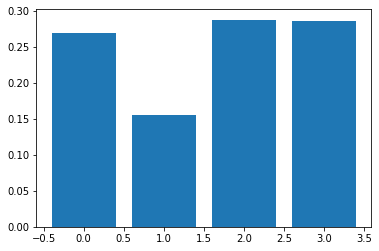

In [36]:
weights_orig = np.random.uniform(0, 1, size=size)
weights_orig = weights_orig/np.sum(weights_orig)

plt.bar(range(len(weights_orig)), weights_orig)

In [53]:
delta_w = 1e-2
if_Jeffreys = True
n_steps = np.int(1e5)

proposal_full = {'fun': proposal, 'args': ([delta_w])}
energy_fun_full = {'fun': energy_fun, 'args': ([weights_orig, if_Jeffreys, size])}

out = run_Metropolis(weights_orig, proposal=proposal_full, energy_function=energy_fun_full, n_steps=n_steps)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

av. acceptance:  0.81251
0.23718717397217343
0.014617369352987868


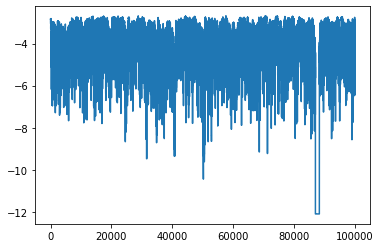

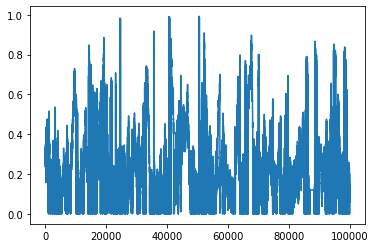

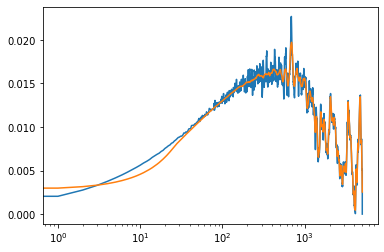

In [54]:
print('av. acceptance: ', out[3])

plt.plot(out[1])

plt.figure()
plt.plot(out[2])

print(np.mean(out[2]))

blocks = block_analysis(out[2], delta=10)

epsilons = blocks[3]
smooth_epsilons = blocks[4]

opt_epsilon = blocks[2]
print(opt_epsilon)

plt.figure()
plt.plot(epsilons, '-')
plt.plot(smooth_epsilons, '-')
plt.xscale('log')

In [55]:
av_accept = out[3]
av_pop = [blocks[0], blocks[1], blocks[2]]

values[size] = [av_accept] + av_pop

In [56]:
weights_double = double(weights_orig)

In [57]:
proposal_full = {'fun': proposal, 'args': ([delta_w])}
energy_fun_full = {'fun': energy_fun, 'args': ([weights_double, if_Jeffreys, size])}  # here size is the initial one

out = run_Metropolis(weights_double, proposal=proposal_full, energy_function=energy_fun_full, n_steps=n_steps)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

av. acceptance:  0.58302
0.2435377123016215
0.013991233975579541


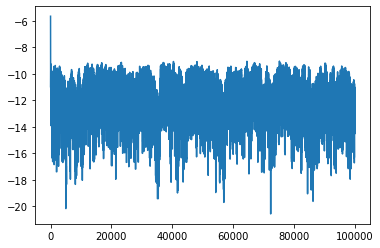

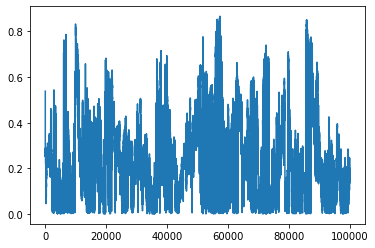

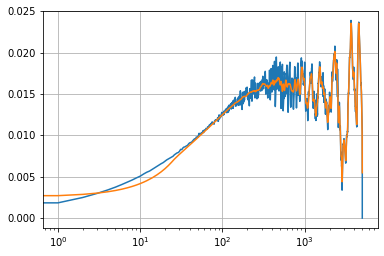

In [58]:
print('av. acceptance: ', out[3])

plt.plot(out[1])

plt.figure()
plt.plot(out[2])

print(np.mean(out[2]))

blocks = block_analysis(out[2], delta=10)

epsilons = blocks[3]
smooth_epsilons = blocks[4]

opt_epsilon = blocks[2]
print(opt_epsilon)

plt.figure()
plt.plot(epsilons, '-')
plt.plot(smooth_epsilons, '-')
plt.xscale('log')
plt.grid()

In [59]:
av_accept = out[3]
av_pop = [blocks[0], blocks[1], blocks[2]]

values[size*2] = [av_accept] + av_pop

In [60]:
values

{4: [0.81251,
  0.23718717397217343,
  0.0006529610028237236,
  0.014617369352987868],
 8: [0.58302, 0.2435377123016215, 0.0005840756702740792, 0.013991233975579541]}

In [46]:
values

{4: [0.98837,
  0.27129419169203484,
  0.0005893140287874697,
  0.012157490451257644],
 8: [0.98355, 0.2507550769153702, 0.0004570420597290718, 0.008866495857542603]}

<ErrorbarContainer object of 3 artists>

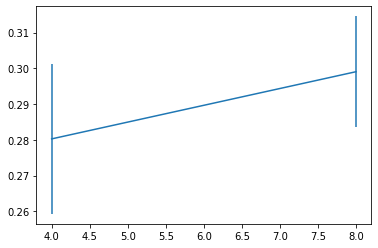

In [34]:
plt.errorbar(values.keys(), [values[i][1] for i in values.keys()], yerr=[values[i][3] for i in values.keys()])


In [70]:
import pandas

In [73]:
av_pop = [blocks[0], blocks[1], blocks[2]]

cols = ['av. accept', 'av. value', 'std', 'block error']
temp = pandas.DataFrame([av_accept] + av_pop, index=cols, columns=[0]).T
temp.to_csv('values.txt')

### analysis

In [43]:
root_path = '../Results/sampling_frames/'
dir_list = os.listdir(root_path)

my_dfs = {}

for i, s in enumerate(dir_list):
    my_dfs[i] = pandas.read_csv(root_path + dir_list[i]).iloc[:, 1:]

my_df = pandas.concat(my_dfs)
my_df['name'] = dir_list
del my_dfs

my_df = my_df.sort_values(['n_steps', 'size', 'if_Jeffreys', 'n_times'], ignore_index=True)

my_df = my_df[my_df['size'] == 20]

my_df = my_df[my_df['n_steps'] == 10000000]

my_df

,size,seed,delta w,n_steps,n_times,if_Jeffreys,av. accept,av. value,std,block error,name
60,20.0,1.0,0.01,10000000.0,1.0,0.0,0.930523,0.051315,0.000015,0.000206,values_2024_12_17_11_17_44_661400.txt
61,20.0,1.0,0.01,10000000.0,2.0,0.0,0.930572,0.051526,0.000015,0.000209,values_2024_12_17_11_12_45_922748.txt
62,20.0,1.0,0.01,10000000.0,3.0,0.0,0.930375,0.051321,0.000015,0.000205,values_2024_12_17_11_21_24_221950.txt
63,20.0,1.0,0.01,10000000.0,4.0,0.0,0.930221,0.051335,0.000015,0.000212,values_2024_12_17_11_20_27_485043.txt
64,20.0,1.0,0.01,10000000.0,5.0,0.0,0.930472,0.051439,0.000015,0.000204,values_2024_12_17_11_21_24_350747.txt
65,20.0,1.0,0.01,10000000.0,7.0,0.0,0.930450,0.051304,0.000015,0.000201,values_2024_12_17_11_16_56_368523.txt
66,20.0,1.0,0.01,10000000.0,8.0,0.0,0.930339,0.051373,0.000015,0.000206,values_2024_12_17_11_13_01_327572.txt
67,20.0,1.0,0.01,10000000.0,9.0,0.0,0.930312,0.051169,0.000015,0.000209,values_2024_12_17_11_19_36_573296.txt
68,20.0,1.0,0.01,10000000.0,10.0,0.0,0.930280,0.051329,0.000015,0.000205,values_2024_12_17_11_24_39_851503.txt
69,20.0,1.0,0.01,10000000.0,11.0,0.0,0.930441,0.051349,0.000015,0.000207,values_2024_12_17_11_19_23_065697.txt


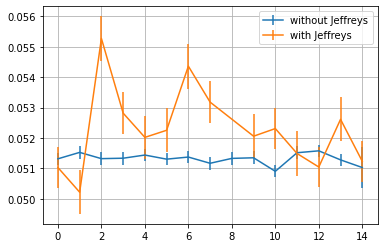

In [36]:
upto = 15

x = np.arange(upto)
plt.errorbar(x, my_df.iloc[:upto]['av. value'], my_df.iloc[:upto]['block error'], label='without Jeffreys')

x = list(set(x)- set([8]))
plt.errorbar(x, my_df.iloc[(upto - 1):(2*upto)]['av. value'], my_df.iloc[(upto - 1):(2*upto)]['block error'], label='with Jeffreys')

plt.legend()
plt.grid()